# I. Descripción del problema e inspección del conjunto de datos

## Descripcion del problema


En el mundo de la computacion actual, la creciente popularidad de los servicios de computacion en la nube han incrementado su demanda a pasos agigantados. La comodidad y simplicad que ofrece los servicios de computacion en la nube a los clientes representa retos constantes para los proovedores que deben asegurar la disponibilidad y estabilidad de su servicios por el mayor tiempo posible.

Estos altos estandares y demanda de los servicios de computacion en la nube generan altos niveles de estres sobre la infraestructura de los provedores de servicios, generando comportamientos anomalos que puedan llevar a fallos y posibles colapsos de infraestructura si no son identificados y mitigados de manera efectiva.

Es por ello que se desarrollaran los experimentos presentes en este documento, Donde el objetivo principal es entrenar un modelo de aprendizaje de maquinas que sea capaz de detectar comportamientos anomalos o peligrosos que se presenten en la infraestructura de de servicios de computacion en la nube.

Para cumplir el objetivo, se realizara el entrenamiento y prueba de modelos con el siguiente dataset:

https://www.kaggle.com/datasets/sandhyapeesara/cloud-anomaly-data

El cual contiene variables como el uso de CPU, uso de memoria, trafico de red, etc. Adicionalmente, el dataset categoriza los registros en 2 clases de comportamiento: Normal (0) y anomalo (1)

## Librerias utilizadas

In [16]:
#Modelos

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import tree
import tensorflow as tf
from tensorflow.keras import layers, models, metrics
import keras_tuner as kt
from tensorflow import keras

#Metricas

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, f1_score

#Ajuste de datos

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

#Utilidades

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import kagglehub
from kagglehub import KaggleDatasetAdapter

import logging
logging.getLogger('keras.src.saving.saving_lib').setLevel(logging.ERROR)

Para cargar el conjunto de datos, utilizamos la librería KaggleHub, la cual nos permite acceder directamente a un dataset alojado en Kaggle y cargarlo en un DataFrame de Pandas. Posteriormente, usamos la función info() de Pandas para obtener un resumen detallado del contenido del archivo.

In [3]:
#Cargando datos
anomalies = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "sandhyapeesara/cloud-anomaly-data",
  "Cloud_Anomaly_Dataset.csv"
)
#Informacion de los datos
anomalies.info()

100%|██████████| 37.4M/37.4M [00:01<00:00, 34.1MB/s]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277570 entries, 0 to 277569
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   vm_id                      249595 non-null  object 
 1   timestamp                  277570 non-null  object 
 2   cpu_usage                  250130 non-null  float64
 3   memory_usage               249775 non-null  float64
 4   network_traffic            249725 non-null  float64
 5   power_consumption          250018 non-null  float64
 6   num_executed_instructions  249637 non-null  float64
 7   execution_time             249960 non-null  float64
 8   energy_efficiency          249616 non-null  float64
 9   task_type                  249580 non-null  object 
 10  task_priority              249674 non-null  object 
 11  task_status                249621 non-null  object 
 12  Anomaly status             277570 non-null  int64  
dtypes: float64(7), int64(1), obje

El dataset está conformado por 277570 ejemplos de métricas recopiladas de máquinas virtuales en la nube, en estos encontramos inicialmente 12 variables predictoras y la variable a predecir, la cual es Anomaly status.

## Resumen estadistico

In [ ]:
#Resumen estadistico de las variables numericas de los datos
anomalies.describe()

,cpu_usage,memory_usage,network_traffic,power_consumption,num_executed_instructions,execution_time,energy_efficiency,Anomaly status
count,250130.000000,249775.000000,249725.000000,250018.000000,249637.000000,249960.000000,249616.000000,277570.000000
mean,50.013258,49.967249,500.554083,249.987238,5002.490284,50.011964,0.500369,0.059999
std,28.895806,28.879090,288.787794,144.662676,2882.806422,28.837634,0.288547,0.237486
min,0.000071,0.000016,0.002542,0.000802,0.000000,0.000172,0.000004,0.000000
25%,24.880023,24.965105,250.298114,124.199907,2506.000000,25.098016,0.250375,0.000000
50%,50.023806,49.912051,500.736963,250.397212,5000.000000,50.005593,0.500834,0.000000
75%,75.097896,74.960052,750.720026,375.485305,7499.000000,75.043715,0.750112,0.000000
max,99.999171,99.999907,999.998686,499.998819,9999.000000,99.998831,0.999994,1.000000


## Revision de valores nulos

In [ ]:
#Verificando valores nulos en los datos
anomalies.isna().sum()

vm_id                        27975
timestamp                        0
cpu_usage                    27440
memory_usage                 27795
network_traffic              27845
power_consumption            27552
num_executed_instructions    27933
execution_time               27610
energy_efficiency            27954
task_type                    27990
task_priority                27896
task_status                  27949
Anomaly status                   0
dtype: int64

Una considerable cantidad de registros contienen valores nulos en una o mas variables de la tabla

## Representacion visual de datos

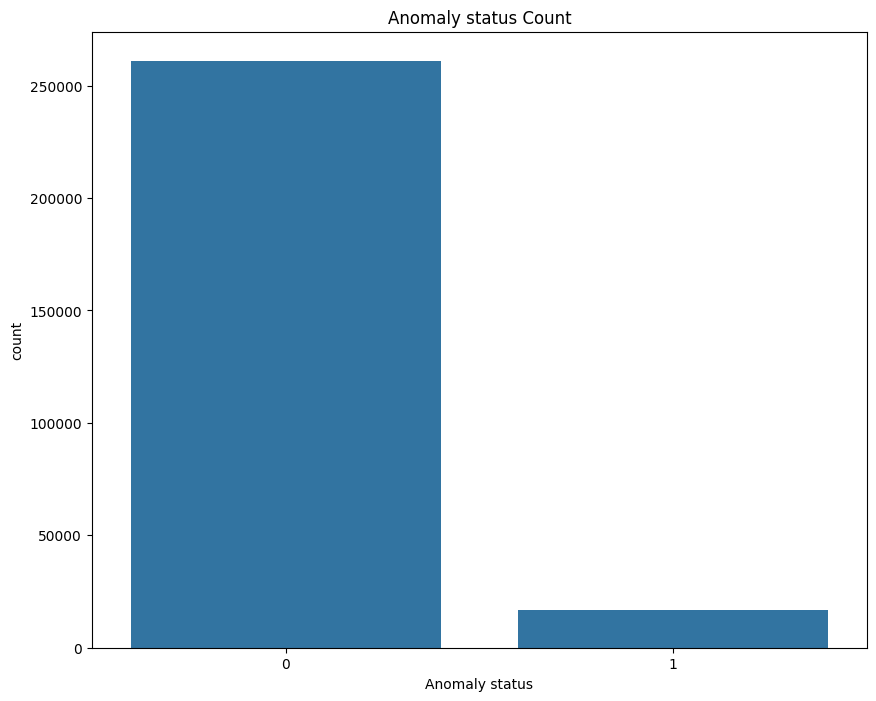

In [ ]:
# Diagrama de barras de la clase normal y la clase anomala
ax=plt.subplots(1,1,figsize=(10,8))
sns.countplot(x='Anomaly status',data=anomalies)
plt.title("Anomaly status Count")
plt.show()

Observando la distribucuion de los datos de manera grafica se observa que los registros ingresados con comportamientos normales tienen una mucha mayor representacion que los datos anomalos dentro del dataset, por lo que es necesario implementar tecnicas de balanceo.

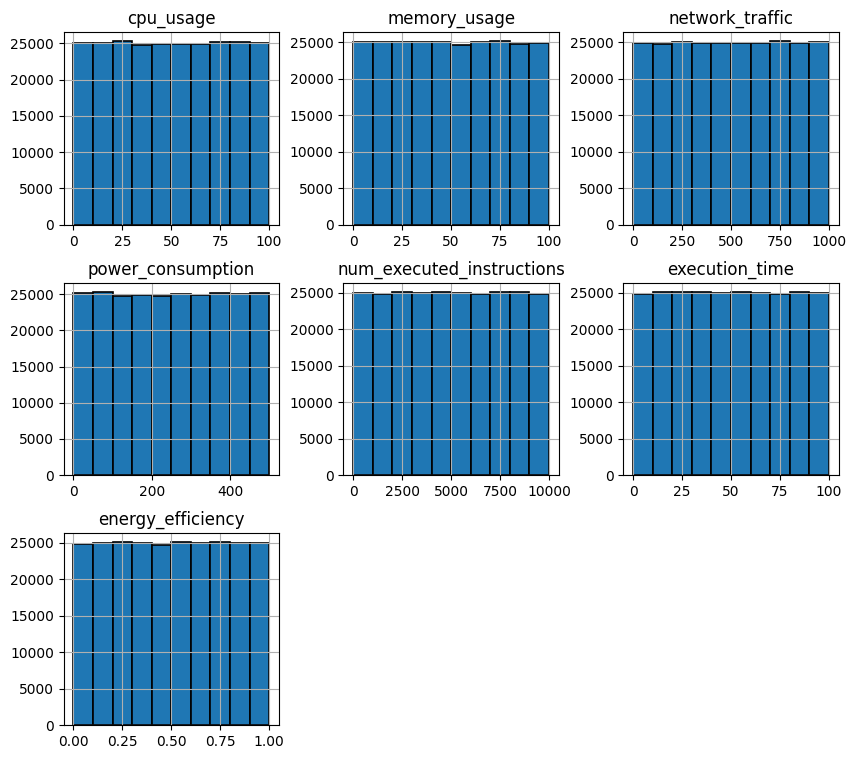

In [ ]:
#Histogramas de las variables predictoras
anomalies_var = anomalies.drop(['Anomaly status'], axis=1)
anomalies_var.hist(edgecolor='black', linewidth=1.2)
fig=plt.gcf()
fig.set_size_inches(10, 9)
plt.show()

## Inspeccion de variables predictoras relacionadas

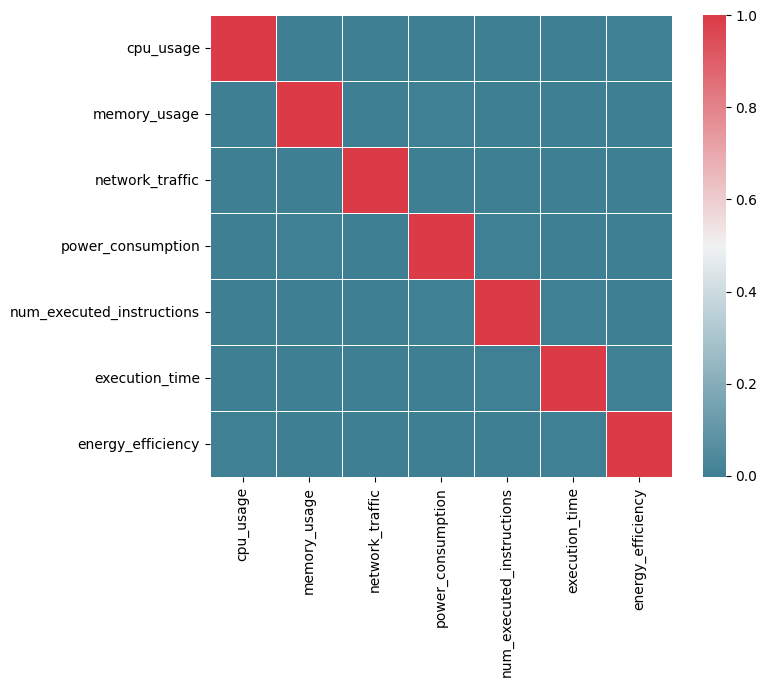

In [ ]:
X_train = anomalies.drop(['Anomaly status','task_type', 'task_priority', 'task_status','vm_id','timestamp'], axis=1) # Separa las variables predictoras de las variable a predecir
y_train = anomalies['Anomaly status']

#Mapa de calor de correlacion entre variables
f, ax = plt.subplots(figsize=(8, 6))
corr = X_train.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool),
          cmap=sns.diverging_palette(220, 10, as_cmap=True),square=True, ax=ax, linewidths=.5)
plt.show()

La matriz de correlacion de las variables predictoras seleccionadas revela que estas presentan un nulo nivel de correlacion entre ellas, por lo que todas pueden ser consideradas para el entrenamiento de los modelos de aprendizaje de maquinas a desarrollar

# II. Diseño de experimentos y recoleccion de resultados

Antes de que los experimentos se puedan llevar a cabo, se deben realizar un conjunto de ajustes al dataset. Esto con el fin de que los datos sean faciles de procesar e interpretar para los modelos, ademas de que existan suficientes ejemplares para que estos identifiquen precisamente las clases que queremos identificar

## Ajuste de datos

Se observo que el dataset en su estado base tiene un alto desbalance donde los datos anomalos representan, aproximadamente, el 5.8% de los datos, mientras que los registros normales del estado de la infraestructura representa la dominante mayoria.

Por estas mismas razones, es necesario aplicar tecnicas de balanceo a los datos como Oversampling o Undersampling, con el objetivo de que los modelos tengan una buena distribucion en los ejemplos a observar y no presenten sesgos una vez sean puestos a prueba

Para el proceso de balanceo se empleara el metodo SMOTE de la libreria ibmlearn, el cual va a realizar oversampling sobre la clase anomala

### Balanceo de datos

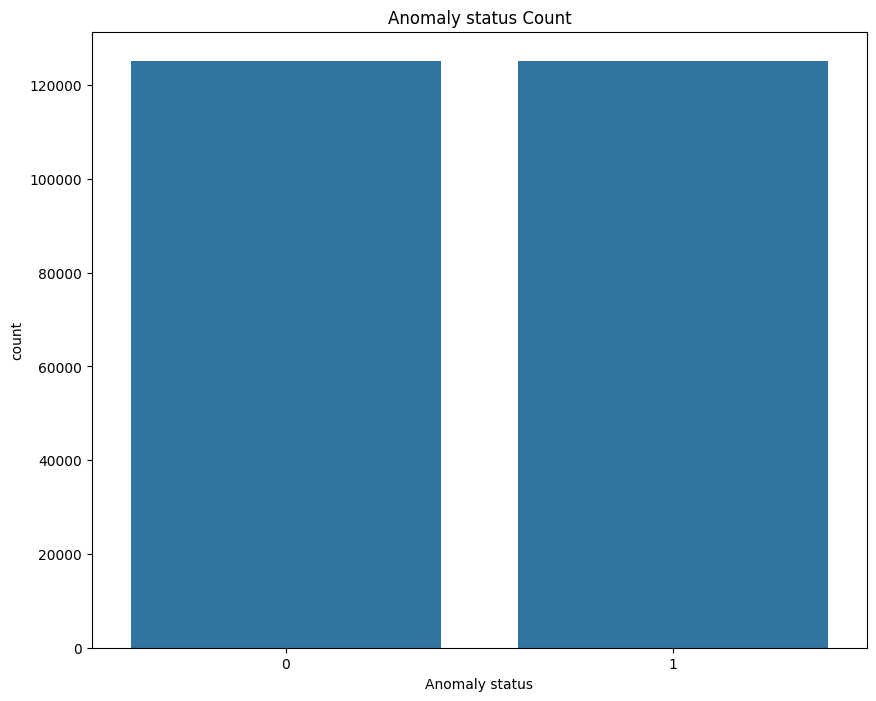

In [4]:
#Se retiran los datos nulos de dataset para unicamente utilizar registros completos
newAnom = anomalies.dropna(subset=['cpu_usage', 'memory_usage', 'network_traffic', 'power_consumption',
                   'num_executed_instructions', 'execution_time', 'energy_efficiency'])

#Se retiran las variables que no van a ser usadas dentro del estudio
newAnom = newAnom.drop(columns=['vm_id', 'timestamp', 'task_type', 'task_priority', 'task_status'])

#Separamos variables predictoras de las variables a predecir
X = newAnom.drop(columns=['Anomaly status'])
y = newAnom['Anomaly status']

#Aplicamos balanceo por medio de smote
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

newAnomResampled = pd.DataFrame(X_resampled, columns=X.columns)
newAnomResampled['Anomaly status'] = y_resampled

#Graficamos despues de aplicar oversampling
ax = plt.subplots(1, 1, figsize=(10, 8))
sns.countplot(x='Anomaly status', data=newAnomResampled)
plt.title("Anomaly status Count")
plt.show()

Despues de este proceso, ya tenemos un balance adecuado en el dataset para el entrenamiento supervisado de los modelos. Sin embargo, estos datos aun se encuentran en sus medidas y formatos normales, provenientes de los registros.

A continuacion se les aplicara un proceso de estandarizacion, de modo que todas las medidas esten comprendidas en un rango entre 0 y 1

In [5]:
#Se divide el dataset en un conjunto de datos de entrenamiento y un conjunto de datos de prueba
x_train, x_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.30)

#se realiza la estandarizacion de variables predictoras en el bnco de entrenamiento y prueba
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(x_test)

## Modelos de aprendizaje de maquina

En este bloque se va a desarrollar el entrenamiento de 4 modelos de clasificacion de apredizaje de maquina, cada uno con una tecnica distinta:

- Regresion logistica
- Arboles de decision
- Random forest
- Redes neuronales

Debido a la naturaleza de nuestro problema, identificar anomalias de comportamiento en infraestructura en la nube, debemos priorizar la reduccion de falsos positivos dentro de los modelos que se van a implementar. Para identificar que tan bueno es un conjunto de parametros dentro de un modelo, siguiendo dicho criterio, seleccionamos la metrica de "Recall"
Para maximar los resultados de sensibilidad de cada modelo, se realizara un proceso de exploracion de parametros utilizando el metodo GridSearchCV, en busqueda de la configuracion de parametros que ofrezca los mejores resultados para el cada modelo.

### Regresion logistica

#### Prueba con parametros por defecto

F1 a datos de entrenamiento: 78.24
F1 a datos de prueba: 78.35

              precision    recall  f1-score   support

           0       0.82      0.69      0.75     37525
           1       0.73      0.85      0.78     37559

    accuracy                           0.77     75084
   macro avg       0.77      0.77      0.76     75084
weighted avg       0.77      0.77      0.76     75084



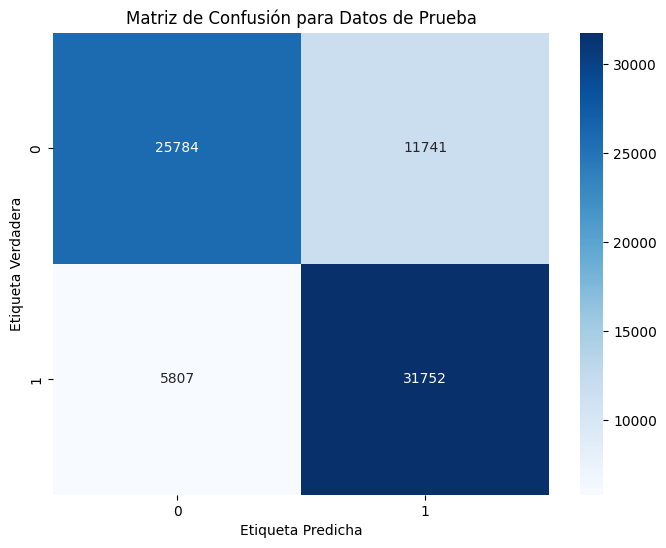

In [ ]:
lr = LogisticRegression()

#Entrenamiento del modelo con banco de entrenamieno escalado
lr.fit(X_train_scaled, y_train)

#Realizacion de predicciones con datos de entrenamiento y prueba
y_pred_train = lr.predict(X_train_scaled)
y_pred_test = lr.predict(X_test_scaled)

#Calculo de porcentaje de recall para ambas predicciones
lr_train_f1= f1_score(y_true= y_train, y_pred = y_pred_train) * 100
lr_test_f1 = f1_score(y_true= y_test, y_pred = y_pred_test) * 100

print('F1 a datos de entrenamiento: {:.2f}'.format(lr_train_f1))
print('F1 a datos de prueba: {:.2f}\n'.format(lr_test_f1))
print(classification_report(y_test, y_pred_test))

cmatrix = confusion_matrix(y_test, y_pred_test)
labels = np.unique(y_test)
df_cm = pd.DataFrame(cmatrix, index=labels, columns=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='d')
plt.title("Matriz de Confusión para Datos de Prueba")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Verdadera")
plt.show()

Se observa un buen resultado buena en la estadistica de sensibilidad del modelo. Esto implica que, con los parametros por defecto del modelo de regresion logistica ofrecen una buena tasa de identificacion de anomalias, donde se identificaron correctamente el 84% de estas tanto en los datos de prueba, como en los datos de entrenamiento.
Sin embargo, esta tasa aun representa una considerable cantidad de falsos negativos que, en contextos reales, pueden representar grandes riesgos si no se identifican correctamente.

#### Busqueda de parametros optimos

In [ ]:
# Definimos los valores posibles para realizar las combinaciones de hiperparametros
param_grid = {
    'C': [0.00001, 0.0001, 0.001],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [500,600,700,800]
}

# Se realiza la busqueda de parametros con GridSearchCV, juzgando por la estadistica de sensibilidad
comb = GridSearchCV(lr, param_grid, cv = 5, scoring = 'f1', n_jobs=-1)

comb.fit(X_train_scaled,y_train)

print("Mejor combinacion de parametros: {:} ".format(comb.best_params_))
print("Puntaje de mejores parametros: {:.2}".format(comb.best_score_))

Mejor combinacion de parametros: {'C': 1e-05, 'max_iter': 700, 'penalty': 'l2', 'solver': 'saga'} 
Puntaje de mejores parametros: 0.79


#### Prueba con mejores parametros encontrados

F1 a datos de entrenamiento: 78.66
F1 a datos de prueba: 78.87

              precision    recall  f1-score   support

           0       0.84      0.67      0.74     37525
           1       0.72      0.87      0.79     37559

    accuracy                           0.77     75084
   macro avg       0.78      0.77      0.76     75084
weighted avg       0.78      0.77      0.76     75084



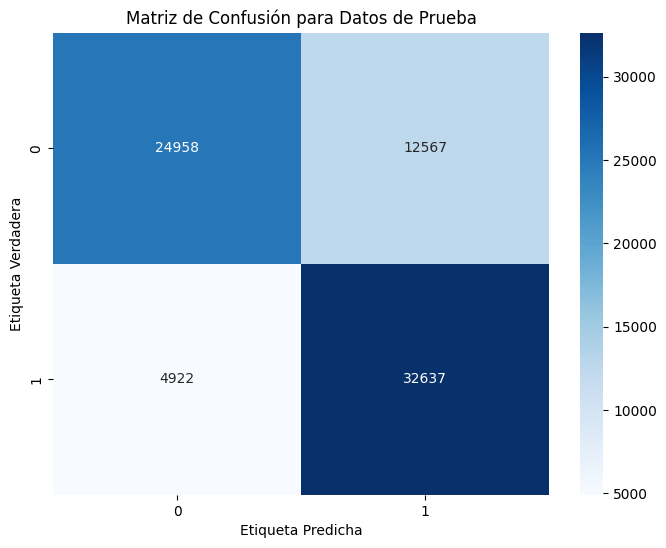

In [ ]:
lr = LogisticRegression(C=0.00001 ,max_iter=500, penalty='l2', solver='liblinear')

#Entrenamiento del modelo con banco de entrenamieno escalado
lr.fit(X_train_scaled, y_train)

#Realizacion de predicciones con datos de entrenamiento y prueba
y_pred_train = lr.predict(X_train_scaled)
y_pred_test = lr.predict(X_test_scaled)

#Calculo de porcentaje de recall para ambas predicciones
lr_train_f1= f1_score(y_true= y_train, y_pred = y_pred_train) * 100
lr_test_f1 = f1_score(y_true= y_test, y_pred = y_pred_test) * 100

print('F1 a datos de entrenamiento: {:.2f}'.format(lr_train_f1))
print('F1 a datos de prueba: {:.2f}\n'.format(lr_test_f1))
print(classification_report(y_test, y_pred_test))

cmatrix = confusion_matrix(y_test, y_pred_test)
labels = np.unique(y_test)
df_cm = pd.DataFrame(cmatrix, index=labels, columns=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='d')
plt.title("Matriz de Confusión para Datos de Prueba")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Verdadera")
plt.show()

Se observa un nivel relativamente constante en los resultados de precision con los nuevos hiperparametros encontrados a travez de GridSearchCV, los cuales sacrifican la sensibilidad del modelo con respecto a los datos normales, por mayor reconocimiento frente a los valores anomalos.

### Arboles de decision

#### Prueba con parametros por defecto

F1 a datos de entrenamiento: 100.00
F1 a datos de prueba: 81.63

              precision    recall  f1-score   support

           0       0.82      0.80      0.81     37510
           1       0.80      0.83      0.82     37574

    accuracy                           0.81     75084
   macro avg       0.81      0.81      0.81     75084
weighted avg       0.81      0.81      0.81     75084



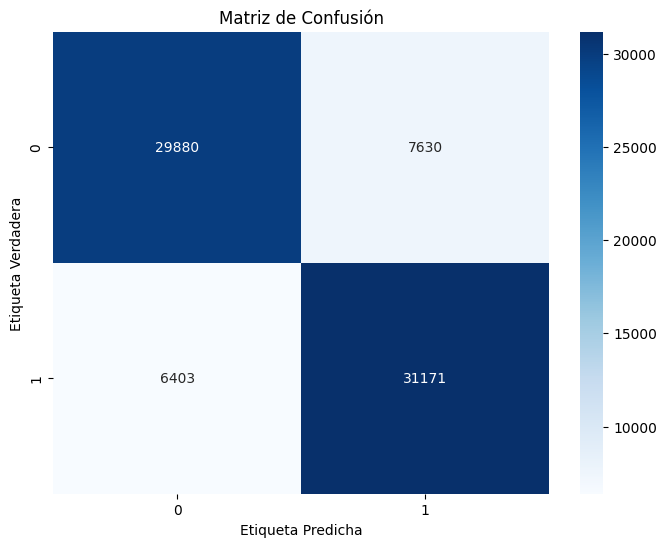

In [ ]:
dt = tree.DecisionTreeClassifier()

# Entrenamiento del arbol
dt.fit(X_train_scaled, y_train)

#Realizacion de predicciones con datos de entrenamiento y prueba
y_pred_train = dt.predict(X_train_scaled)
y_pred_test = dt.predict(X_test_scaled)

#Calculo de porcentaje de recall para ambas predicciones
dt_train_f1= f1_score(y_true= y_train, y_pred = y_pred_train) * 100
dt_test_f1 = f1_score(y_true= y_test, y_pred = y_pred_test) * 100

print('F1 a datos de entrenamiento: {:.2f}'.format(dt_train_f1))
print('F1 a datos de prueba: {:.2f}\n'.format(dt_test_f1))
print(classification_report(y_test, y_pred_test))

cmatrix = confusion_matrix(y_test, y_pred_test)
labels = np.unique(y_test)
df_cm = pd.DataFrame(cmatrix, index=labels, columns=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='d')
plt.title("Matriz de Confusión")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Verdadera")
plt.show()

#### Busqueda de parametros optimos


In [ ]:
# Definicmos los valores posibles para los hiperparametros

param_grid = {
    'criterion': ['entropy', 'gini'],  # Regularization strength
    'splitter': ['random','best'],
    'min_samples_split' : [8,10,12,14],  # Regularization type
    'max_depth': [17,20,23,26,29],  # Optimization algorithm
    'min_samples_leaf': [25,50,75,100]  # Maximum iterations
}

# Se realiza la busqueda de parametros con GridSearchCV, juzgando por la estadistica de sensibilidad
comb = GridSearchCV(dt, param_grid, cv = 5, scoring = 'f1', n_jobs=-1)

comb.fit(X_train_scaled,y_train)

print("Mejor combinacion de parametros: {:}".format(comb.best_params_))
print("Puntaje de mejores parametros: {:.2}".format(comb.best_score_))

Mejor combinacion de parametros: {'criterion': 'gini', 'max_depth': 17, 'min_samples_leaf': 25, 'min_samples_split': 12, 'splitter': 'best'}
Puntaje de mejores parametros: 0.84


#### Prueba con mejores parametros encontrados

F1 a datos de entrenamiento: 86.23
F1 a datos de prueba: 83.74

              precision    recall  f1-score   support

           0       0.88      0.76      0.81     37510
           1       0.79      0.90      0.84     37574

    accuracy                           0.83     75084
   macro avg       0.83      0.83      0.83     75084
weighted avg       0.83      0.83      0.83     75084



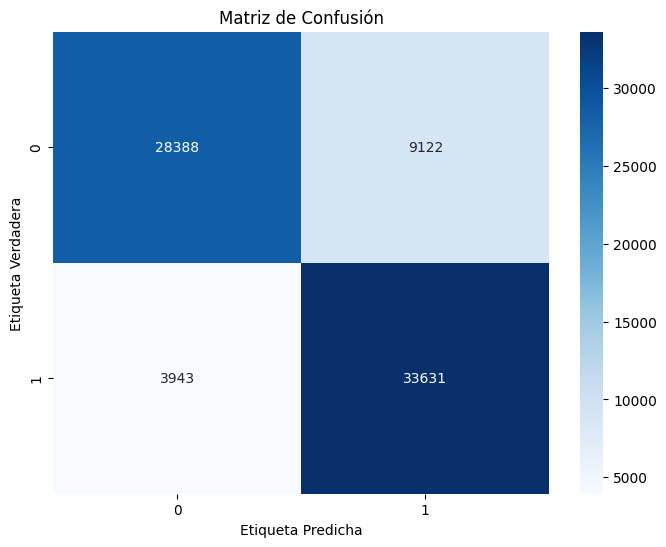

In [ ]:
dt = tree.DecisionTreeClassifier(criterion='gini', max_depth=17, min_samples_leaf=25, min_samples_split=8, splitter='best')

dt.fit(X_train_scaled, y_train)

#Realizacion de predicciones con datos de entrenamiento y prueba
y_pred_train = dt.predict(X_train_scaled)
y_pred_test = dt.predict(X_test_scaled)

#Calculo de porcentaje de recall para ambas predicciones
dt_train_f1= f1_score(y_true= y_train, y_pred = y_pred_train) * 100
dt_test_f1 = f1_score(y_true= y_test, y_pred = y_pred_test) * 100

print('F1 a datos de entrenamiento: {:.2f}'.format(dt_train_f1))
print('F1 a datos de prueba: {:.2f}\n'.format(dt_test_f1))
print(classification_report(y_test, y_pred_test))

cmatrix = confusion_matrix(y_test, y_pred_test)
labels = np.unique(y_test)
df_cm = pd.DataFrame(cmatrix, index=labels, columns=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='d')
plt.title("Matriz de Confusión")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Verdadera")
plt.show()

### Random forest

#### Prueba con parametros por defecto

F1 a datos de entrenamiento: 86.23
F1 a datos de prueba: 84.10

              precision    recall  f1-score   support

           0       0.94      0.80      0.86     37599
           1       0.82      0.95      0.88     37485

    accuracy                           0.87     75084
   macro avg       0.88      0.87      0.87     75084
weighted avg       0.88      0.87      0.87     75084



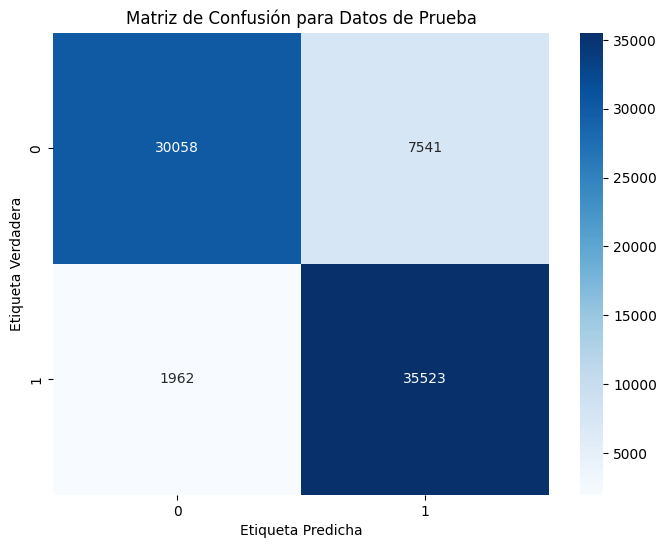

In [ ]:
rf = RandomForestClassifier()

rf.fit(X_train_scaled, y_train)

#Realizacion de predicciones con datos de entrenamiento y prueba
y_pred_train = rf.predict(X_train_scaled)
y_pred_test = rf.predict(X_test_scaled)

#Calculo de porcentaje de recall para ambas predicciones
rf_train_f1= f1_score(y_true= y_train, y_pred = y_pred_train) * 100
rf_test_f1 = f1_score(y_true= y_test, y_pred = y_pred_test) * 100

print('F1 a datos de entrenamiento: {:.2f}'.format(dt_train_f1))
print('F1 a datos de prueba: {:.2f}\n'.format(dt_test_f1))
print(classification_report(y_test, y_pred_test))

cmatrix = confusion_matrix(y_test, y_pred_test)
labels = np.unique(y_test)
df_cm = pd.DataFrame(cmatrix, index=labels, columns=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='d')
plt.title("Matriz de Confusión para Datos de Prueba")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Verdadera")
plt.show()

#### Busqueda de parametros optimos

In [ ]:
param_grid = {
    'n_estimators': [125,100,150],
    'criterion': ['entropy', 'gini'],  # Regularization strength
    'max_depth': [None, 17,20,23],  # Optimization algorithm
    'min_samples_leaf': [10,25,50,75]  # Maximum iterations
}

comb = RandomizedSearchCV(rf, param_grid, cv = 5, scoring = 'f1', n_jobs=-1, n_iter=15, random_state=42)

comb.fit(X_train_scaled,y_train)

print("Mejor combinacion de parametros: {:}".format(comb.best_params_))
print("Puntaje de mejores parametros: {:.2}".format(comb.best_score_))

Mejor combinacion de parametros: {'n_estimators': 125, 'min_samples_leaf': 10, 'max_depth': None, 'criterion': 'entropy'}
Puntaje de mejores parametros: 0.86


#### Prueba con mejores parametros encontrados

F1 a datos de entrenamiento: 86.23
F1 a datos de prueba: 84.10

              precision    recall  f1-score   support

           0       0.91      0.73      0.81     37599
           1       0.78      0.92      0.84     37485

    accuracy                           0.83     75084
   macro avg       0.84      0.83      0.83     75084
weighted avg       0.84      0.83      0.83     75084



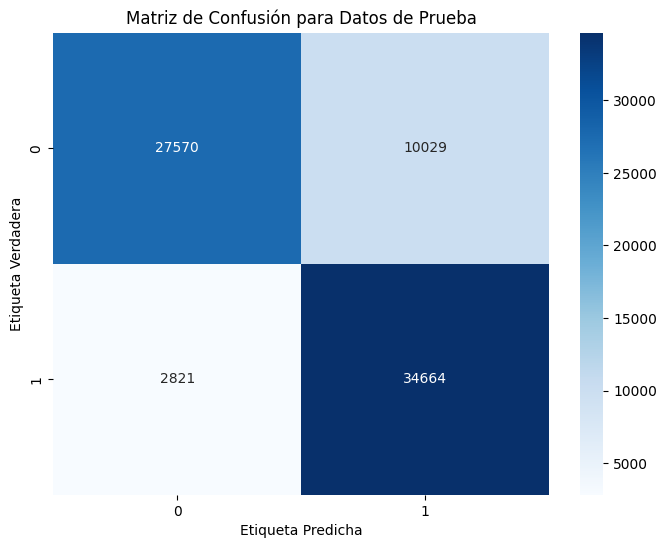

In [ ]:
rf = RandomForestClassifier(criterion= 'entropy', max_depth= 10, min_samples_leaf= 25, n_estimators= 150)

rf.fit(X_train_scaled, y_train)

#Realizacion de predicciones con datos de entrenamiento y prueba
y_pred_train = rf.predict(X_train_scaled)
y_pred_test = rf.predict(X_test_scaled)

#Calculo de porcentaje de recall para ambas predicciones
rf_train_f1= f1_score(y_true= y_train, y_pred = y_pred_train) * 100
rf_test_f1 = f1_score(y_true= y_test, y_pred = y_pred_test) * 100

print('F1 a datos de entrenamiento: {:.2f}'.format(dt_train_f1))
print('F1 a datos de prueba: {:.2f}\n'.format(dt_test_f1))
print(classification_report(y_test, y_pred_test))

cmatrix = confusion_matrix(y_test, y_pred_test)
labels = np.unique(y_test)
df_cm = pd.DataFrame(cmatrix, index=labels, columns=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='d')
plt.title("Matriz de Confusión para Datos de Prueba")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Verdadera")
plt.show()

### Redes neuronales (MLP)

#### Prueba con parametros por defecto

F1 a datos de entrenamiento: 83.83
F1 a datos de prueba: 83.54

              precision    recall  f1-score   support

           0       0.88      0.75      0.81     37510
           1       0.78      0.90      0.84     37574

    accuracy                           0.82     75084
   macro avg       0.83      0.82      0.82     75084
weighted avg       0.83      0.82      0.82     75084



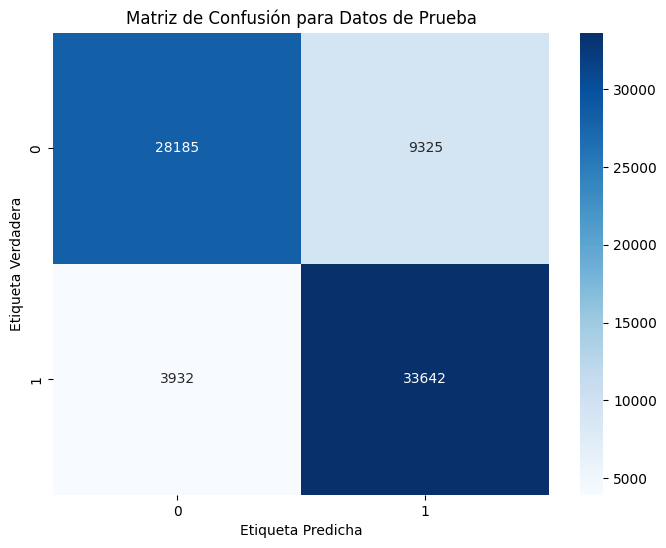

In [ ]:
mlp = MLPClassifier()

mlp.fit(X_train_scaled, y_train)

#Realizacion de predicciones con datos de entrenamiento y prueba
y_pred_train = mlp.predict(X_train_scaled)
y_pred_test = mlp.predict(X_test_scaled)

#Calculo de porcentaje de recall para ambas predicciones
mlp_train_f1= f1_score(y_true= y_train, y_pred = y_pred_train) * 100
mlp_test_f1 = f1_score(y_true= y_test, y_pred = y_pred_test) * 100

print('F1 a datos de entrenamiento: {:.2f}'.format(mlp_train_f1))
print('F1 a datos de prueba: {:.2f}\n'.format(mlp_test_f1))
print(classification_report(y_test, y_pred_test))

cmatrix = confusion_matrix(y_test, y_pred_test)
labels = np.unique(y_test)
df_cm = pd.DataFrame(cmatrix, index=labels, columns=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='d')
plt.title("Matriz de Confusión para Datos de Prueba")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Verdadera")
plt.show()

#### Busqueda de parametros optimos

In [ ]:
param_grid = {
    'hidden_layer_sizes': [(50,50,50),
                           (100,50),
                           (150)],
    'activation': ['relu','tanh'],  # Regularization strength
    'solver': ['adam'],  # Optimization algorithm
    'alpha': [0.001, 0.01],
    'learning_rate' : ['adaptive'],
    'learning_rate_init' : [0.001, 0.01],
    'max_iter' : [500, 700],
    'early_stopping' : [True]
}

comb = RandomizedSearchCV(mlp, param_grid, cv = 3, scoring = 'f1', n_jobs=-1, n_iter=15, random_state=42)

comb.fit(X_train_scaled,y_train)

print("Mejor combinacion de parametros: {:}".format(comb.best_params_))
print("Puntaje de mejores parametros: {:.2}".format(comb.best_score_))

Mejor combinacion de parametros: {'solver': 'adam', 'max_iter': 700, 'learning_rate_init': 0.01, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (50, 50, 50), 'early_stopping': True, 'alpha': 0.001, 'activation': 'relu'}
Puntaje de mejores parametros: 0.84


#### Prueba con mejores parametros encontrados

F1 a datos de entrenamiento: 86.23
F1 a datos de prueba: 83.74

              precision    recall  f1-score   support

           0       0.90      0.73      0.81     37510
           1       0.78      0.92      0.84     37574

    accuracy                           0.83     75084
   macro avg       0.84      0.83      0.83     75084
weighted avg       0.84      0.83      0.83     75084



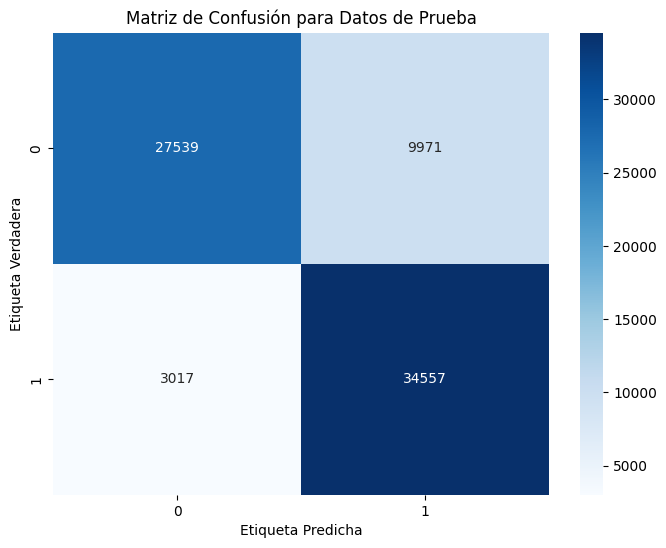

In [ ]:
mlp = MLPClassifier(solver = 'adam', max_iter = 700, learning_rate_init= 0.01, learning_rate= 'adaptive', hidden_layer_sizes= (50, 50, 50), early_stopping= True, alpha= 0.001, activation= 'relu')

mlp.fit(X_train_scaled, y_train)

#Realizacion de predicciones con datos de entrenamiento y prueba
y_pred_train = mlp.predict(X_train_scaled)
y_pred_test = mlp.predict(X_test_scaled)

#Calculo de porcentaje de recall para ambas predicciones
mlp_train_f1= f1_score(y_true= y_train, y_pred = y_pred_train) * 100
mlp_test_f1 = f1_score(y_true= y_test, y_pred = y_pred_test) * 100

print('F1 a datos de entrenamiento: {:.2f}'.format(dt_train_f1))
print('F1 a datos de prueba: {:.2f}\n'.format(dt_test_f1))
print(classification_report(y_test, y_pred_test))

cmatrix = confusion_matrix(y_test, y_pred_test)
labels = np.unique(y_test)
df_cm = pd.DataFrame(cmatrix, index=labels, columns=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='d')
plt.title("Matriz de Confusión para Datos de Prueba")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Verdadera")
plt.show()

### Redes Neuronales Profundas

#### Creacion del modelo

In [18]:
def build_model(hp):
  neurons = hp.Choice('neurons', [128, 64])
  activation = hp.Choice('activation', ['relu', 'tanh', 'elu'])
  dropout = hp.Float('dropout', 0.2, 0.4, step=0.1)
  learning_rate = hp.Choice('learning_rate', [0.001, 0.01])

  model = keras.Sequential([
      layers.Dense(neurons, activation=activation, input_shape=(X_train_scaled.shape[1],)),
      layers.BatchNormalization(),
      layers.Dropout(dropout),

      layers.Dense(neurons//2, activation=activation),
      layers.BatchNormalization(),
      layers.Dropout(dropout),

      layers.Dense(max(neurons//4,16), activation=activation),
      layers.BatchNormalization(),
      layers.Dropout(dropout),

      layers.Dense(8, activation=activation),

      layers.Dense(1, activation='sigmoid')
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
      loss='binary_crossentropy',
      metrics=[keras.metrics.F1Score(threshold=0.5)]
  )
  return model

#### Busqueda de parametros

In [22]:
#Crear tuner
tuner = kt.RandomSearch(hypermodel= build_model, objective = 'val_loss', max_trials=10, overwrite = True)

callbacks = [
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
]

tuner.search(X_train_scaled, y_train, epochs=50, batch_size=256 ,validation_data=(X_test_scaled, y_test), callbacks=callbacks, verbose=1)
best_model = tuner.get_best_models()[0]

Trial 10 Complete [00h 02m 34s]
val_loss: 0.3880443871021271

Best val_loss So Far: 0.37602344155311584
Total elapsed time: 00h 24m 24s


#### Evaluacion del modelo

5475/5475 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
2347/2347 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
F1 a datos de entrenamiento: 84.94
F1 a datos de prueba: 84.80

              precision    recall  f1-score   support

           0       0.92      0.73      0.81     37408
           1       0.78      0.93      0.85     37676

    accuracy                           0.83     75084
   macro avg       0.85      0.83      0.83     75084
weighted avg       0.85      0.83      0.83     75084



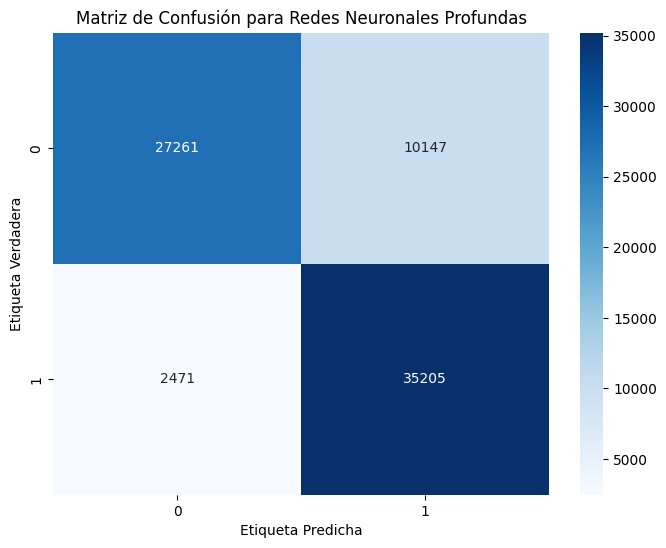

In [23]:
# Obtener el modelo entrenado
y_pred_train =best_model.predict(X_train_scaled)
y_pred_test =best_model.predict(X_test_scaled)

y_pred_test = (y_pred_test > 0.5).astype(int).flatten()
y_pred_train = (y_pred_train > 0.5).astype(int).flatten()

#Calculo de porcentaje de recall para ambas predicciones
kc_train_f1= f1_score(y_true= y_train, y_pred = y_pred_train) * 100
kc_test_f1 = f1_score(y_true= y_test, y_pred = y_pred_test) * 100

print('F1 a datos de entrenamiento: {:.2f}'.format(kc_train_f1))
print('F1 a datos de prueba: {:.2f}\n'.format(kc_test_f1))
print(classification_report(y_test, y_pred_test))

cmatrix = confusion_matrix(y_test, y_pred_test)
labels = np.unique(y_test)
df_cm = pd.DataFrame(cmatrix, index=labels, columns=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='d')
plt.title("Matriz de Confusión para Redes Neuronales Profundas")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Verdadera")
plt.show()

# III. Comparacion de modelos entrenados y conclusiones